In [1]:
import numpy as np # linear algebra
import pandas as pd
import numpy as np
import gym
from gym import wrappers
import time
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
import glob

## Utility Code for testing

In [2]:
np.random.seed(10)
twenty = generate_random_map(20)
MAPS = {
    "20x20": twenty
}

In [3]:
def run_process(env, policy, gamma, render = True):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, gamma , n = 100):
    scores = [run_process(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def get_policy(env,v, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy(env, policy, gamma):
    v = np.zeros(env.nS)
    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v

In [4]:
def run_policy_iteration(env, gamma):
    policy = np.random.choice(env.nA, size=(env.nS))  
    max_iters = 200000
    desc = env.unwrapped.desc
    for i in range(max_iters):
        old_policy_v = compute_policy(env, policy, gamma)
        new_policy = get_policy(env,old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            k=i+1
            break
        policy = new_policy
    return policy,k

In [5]:
def run_value_iteration(env, gamma):
    v = np.zeros(env.nS)  # initialize value-function
    max_iters = 100000
    eps = 1e-20
    desc = env.unwrapped.desc
    for i in range(max_iters):
        prev_v = np.copy(v)
        for s in range(env.nS):
            q_sa = [sum([p*(r + gamma*prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.nA)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            k=i+1
            break
    return v,k

In [6]:
def show_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')
            

    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.savefig(title+".png")
    plt.close()

    return (plt)

In [7]:
def colors():
    return {
        b'S': 'green',
        b'F': 'skyblue',
        b'H': 'black',
        b'G': 'gold',
    }

def directions():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }

## Experiment

In [26]:
def run_Frozen_Lake_policy_iteration(option):
    # 0 = left; 1 = down; 2 = right;  3 = up
    size = 4
    save_opt = None
    if (option == "4x4"):
        environment  = 'FrozenLake-v1'
        env = gym.make(environment)
        save_opt = "4by4"
        size = 4
    else:
        env = FrozenLakeEnv(desc=MAPS["20x20"])
        save_opt = "20by20"
        size = 20
    env = env.unwrapped
    desc = env.unwrapped.desc
    time_array=[0]*10
    gamma_arr=[0]*10
    iters=[0]*10
    list_scores=[0]*10

    
    ### POLICY ITERATION ####
    print('POLICY ITERATION WITH FROZEN LAKE ' + option)
    for i in range(0,10):
        st=time.time()
        best_policy,k = run_policy_iteration(env, gamma = (i+0.5)/10)
        scores = evaluate_policy(env, best_policy, gamma = (i+0.5)/10)
        gamma = (i+0.5)/10
        title = 'Frozen_Lake_' + save_opt + '_Policy_Map_Policy_Iteration_discont_factor_'+ str(gamma)
        end=time.time()
        if i == 9:
            plot = show_policy_map(title,best_policy.reshape(size,size),desc,colors(),directions())
        gamma_arr[i]=(i+0.5)/10
        list_scores[i]=np.mean(scores)
        iters[i] = k
        time_array[i]=end-st
    
    print(gamma_arr)
    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Frozen Lake ' + option + ' PI-Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,list_scores)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Frozen Lake ' + option + ' PI-Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Frozen Lake ' + option + ' PI-Convergence Analysis')
    plt.grid()
    plt.show()

In [32]:
def run_Frozen_Lake_value_iteration(option):
    # 0 = left; 1 = down; 2 = right;  3 = up
    size = 4
    save_opt = None
    if (option == "4x4"):
        environment  = 'FrozenLake-v1'
        env = gym.make(environment)
        save_opt = "4by4"
        size = 4
    else:
        env = FrozenLakeEnv(desc=MAPS["20x20"])
        save_opt = "20by20"
        size = 20
    env = env.unwrapped
    desc = env.unwrapped.desc
    time_array=[0]*10
    gamma_arr=[0]*10
    iters=[0]*10
    list_scores=[0]*10
    
    ### VALUE ITERATION ###
    print('VALUE ITERATION WITH FROZEN LAKE ' + option)
    best_vals=[0]*10
    for i in range(0,10):
        st=time.time()
        best_value,k = run_value_iteration(env, gamma = (i+0.5)/10)
        policy = get_policy(env,best_value, gamma = (i+0.5)/10)
        policy_score = evaluate_policy(env, policy, gamma=(i+0.5)/10, n=1000)
        gamma = (i+0.5)/10
        title = 'Frozen_Lake_' + save_opt + '_Policy_Map_Value_Iteration_discont_factor_'+ str(gamma)
        end=time.time()
        if i == 9:
            plot = show_policy_map(title,policy.reshape(size,size),desc,colors(),directions())
        gamma_arr[i]=(i+0.5)/10
        iters[i]=k
        best_vals[i] = best_value
        list_scores[i]=np.mean(policy_score)
        time_array[i]=end-st

    print(gamma_arr)
    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Frozen Lake ' + option + ' VI-Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,list_scores)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Frozen Lake ' + option + ' VI-Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Frozen Lake ' + option + ' VI-Convergence Analysis')
    plt.grid()
    plt.show()
    
    """
    plt.plot(gamma_arr,best_vals)
    plt.xlabel('Gammas')
    plt.ylabel('Optimal Value')
    plt.legend(['epsilon=0.05','epsilon=0.15','epsilon=0.25','epsilon=0.50','epsilon=0.75','epsilon=0.95'])
    plt.title('Frozen Lake ' + option + ' - Value Iteration - Best Value Analysis')
    plt.grid()
    plt.show()
    """
    

In [10]:
def run_Frozen_Lake_Q_learning(option):
    ### Q-LEARNING #####
    print('Q LEARNING WITH FROZEN LAKE ' + option)
    # 0 = left; 1 = down; 2 = right;  3 = up
    size = 4
    save_opt = None
    if (option == "4x4"):
        environment  = 'FrozenLake-v1'
        env = gym.make(environment)
        save_opt = "4by4"
        size = 4
    else:
        env = FrozenLakeEnv(desc=MAPS["20x20"])
        save_opt = "20by20"
        size = 20
    st = time.time()
    reward_array = []
    iter_array = []
    size_array = []
    chunks_array = []
    averages_array = []
    time_array = []
    Q_array = []
    
    for epsilon in [0.01,0.05,0.1,0.2,0.3, 0.4]:
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        rewards = []
        iters = []
        optimal=[0]*env.observation_space.n
        alpha = 0.85
        gamma = 0.95
        episodes = 30000
        
        if (option == "4x4"):
            environment  = 'FrozenLake-v1'
            env = gym.make(environment)
        else:
            env = FrozenLakeEnv(desc=MAPS["20x20"])

        env = env.unwrapped
        desc = env.unwrapped.desc
        for episode in range(episodes):
            state = env.reset()
            done = False
            t_reward = 0
            max_steps = 1000000
            for i in range(max_steps):
                if done:
                    break        
                current = state
                if np.random.rand() < (epsilon):
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q[current, :])
                state, reward, done, info = env.step(action)
                t_reward += reward
                Q[current, action] += alpha * (reward + gamma * np.max(Q[state, :]) - Q[current, action])
            #epsilon=(1-2.71**(-episode/1000))
            #print(epsilon)
            rewards.append(t_reward)
            iters.append(i)


        for k in range(env.observation_space.n):
            optimal[k]=np.argmax(Q[k, :])

        reward_array.append(rewards)
        iter_array.append(iters)
        Q_array.append(Q)

        env.close()
        end=time.time()
        time_array.append(end-st)

        # Plot results
        def chunk_list(l, n):
            for i in range(0, len(l), n):
                yield l[i:i + n]

        size = int(episodes / 50)
        chunks = list(chunk_list(rewards, size))
        averages = [sum(chunk) / len(chunk) for chunk in chunks]
        size_array.append(size)
        chunks_array.append(chunks)
        averages_array.append(averages)
        
    # print('Frozen Lake ' + option + ' - Q Learning Q Array')
    # print(Q_array)

    # print('Frozen Lake ' + option + ' - Q Learning Reward Array')
    # print(reward_array)

    plt.plot(range(0, len(reward_array[0]), size_array[0]), averages_array[0],label='epsilon=0.01')
    plt.plot(range(0, len(reward_array[1]), size_array[1]), averages_array[1],label='epsilon=0.05')
    plt.plot(range(0, len(reward_array[2]), size_array[2]), averages_array[2],label='epsilon=0.1')
    plt.plot(range(0, len(reward_array[3]), size_array[3]), averages_array[3],label='epsilon=0.2')
    plt.plot(range(0, len(reward_array[2]), size_array[2]), averages_array[2],label='epsilon=0.3')
    plt.plot(range(0, len(reward_array[3]), size_array[3]), averages_array[3],label='epsilon=0.4')
    plt.legend()
    plt.xlabel('Iterations')
    plt.grid()
    plt.title('Frozen Lake ' + option + ' - Q Learning - Constant Epsilon')
    plt.ylabel('Average Reward')
    plt.show()
    
    plt.plot([0.01,0.05,0.1,0.2,0.3, 0.4],time_array)
    plt.xlabel('Epsilon Values')
    plt.grid()
    plt.title('Frozen Lake ' + option + ' - Q Learning')
    plt.ylabel('Execution Time (s)')
    plt.show()


POLICY ITERATION WITH FROZEN LAKE 4x4
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


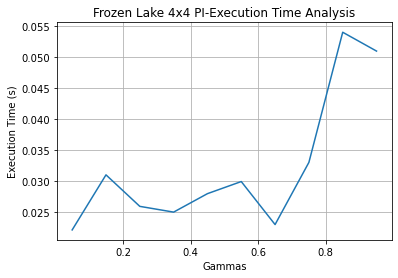

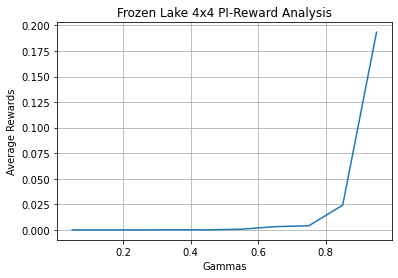

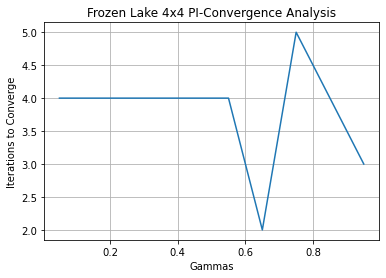

In [30]:
run_Frozen_Lake_policy_iteration("4x4")

VALUE ITERATION WITH FROZEN LAKE 4x4
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


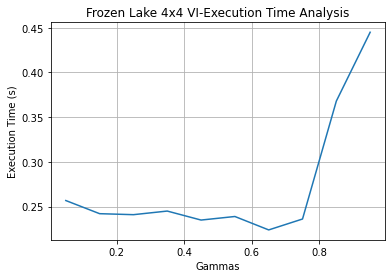

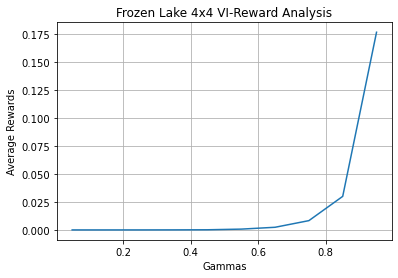

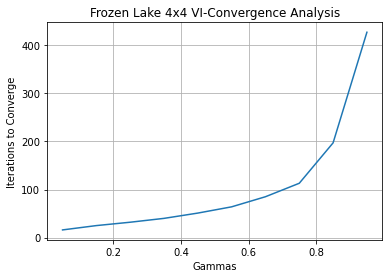

In [33]:
run_Frozen_Lake_value_iteration("4x4")

Q LEARNING WITH FROZEN LAKE 4x4


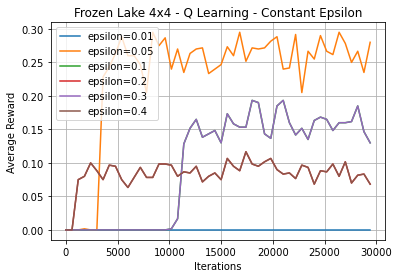

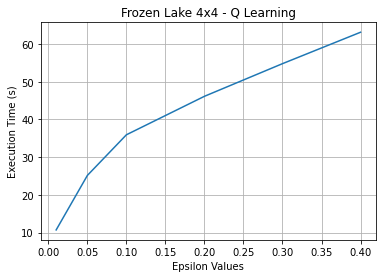

In [19]:
run_Frozen_Lake_Q_learning("4x4")

## Bigger Scale

POLICY ITERATION WITH FROZEN LAKE 20x20
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


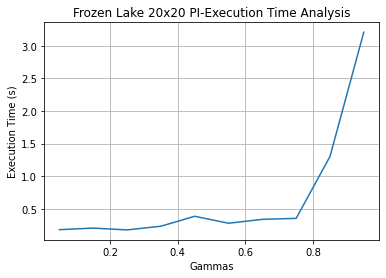

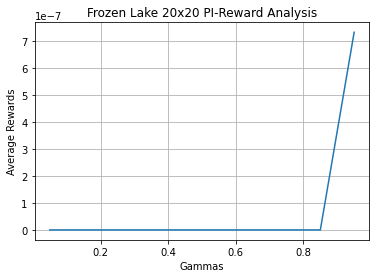

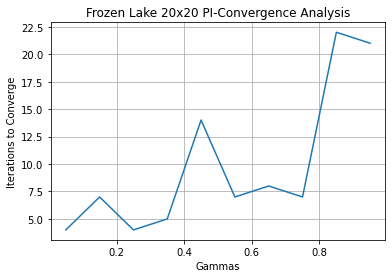

In [34]:
run_Frozen_Lake_policy_iteration("20x20")

VALUE ITERATION WITH FROZEN LAKE 20x20
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


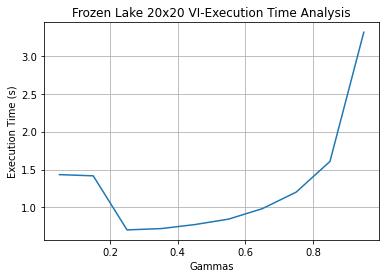

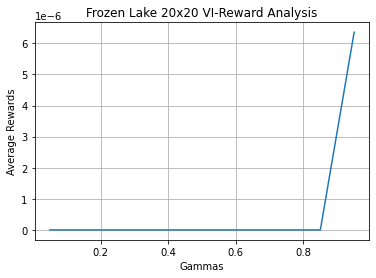

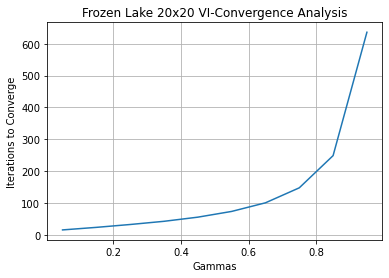

In [35]:
run_Frozen_Lake_value_iteration("20x20")

Q LEARNING WITH FROZEN LAKE 20x20


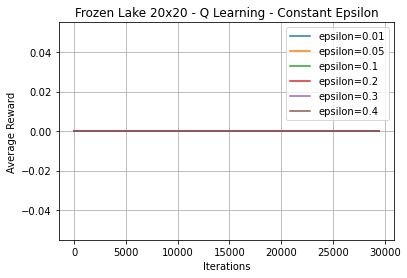

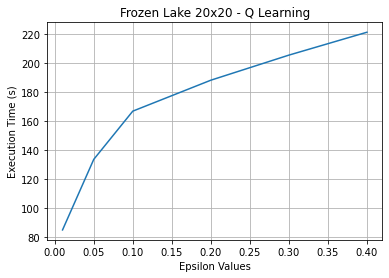

In [20]:
run_Frozen_Lake_Q_learning("20x20")